In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
from scipy.interpolate import LinearNDInterpolator
import plotly.express as px
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib

In [96]:
# GOES FROM MONTLY MSS ANOMALY OBSERVATIONS TO ALL TIME MSS ANOMALY WITH MICROPLASTICS INTERPOLTATED 1x1
directory = "C:/Users/syversk/Desktop/anno_np_sp"
files = os.listdir(directory)
df_list = []
for i in tqdm(range(3, 15)):
    df = pd.read_csv(directory + "/" + files[i])
#Go from montly to all average    
    df_list.append(df)
df = pd.concat(df_list)
df = group_dataframe_temporally(df)
df = interp_microplastics(df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.43it/s]


In [41]:
df["peaks"] = df.apply(lambda row: peak_interp(row.lat, row.lon), axis = 1)

In [43]:
df.corr()

,lon,lat,mss_anomaly_delta_refitted,mss_anomaly_wind_refitted,mss_anomaly_delta_towards,mss_anomaly_wind_towards,mss_anomaly_delta_gdt,mss_anomaly_wind_gdt,micro_mass,abundace,peaks
lon,1.000000,0.127276,-0.016457,-0.031499,-0.054869,-0.071072,-0.019978,-0.030880,-0.114867,-0.185104,-0.046355
lat,0.127276,1.000000,-0.253939,-0.253117,-0.243115,-0.241328,-0.249570,-0.250086,0.360164,0.224396,0.014941
mss_anomaly_delta_refitted,-0.016457,-0.253939,1.000000,0.992620,0.978529,0.967427,0.998455,0.991633,-0.060552,-0.027105,-0.151040
mss_anomaly_wind_refitted,-0.031499,-0.253117,0.992620,1.000000,0.971906,0.980051,0.990593,0.998659,-0.023713,0.012966,-0.118237
mss_anomaly_delta_towards,-0.054869,-0.243115,0.978529,0.971906,1.000000,0.987040,0.984190,0.977996,-0.064994,-0.030306,-0.066804
mss_anomaly_wind_towards,-0.071072,-0.241328,0.967427,0.980051,0.987040,1.000000,0.972046,0.985428,-0.017352,0.021224,-0.026286
mss_anomaly_delta_gdt,-0.019978,-0.249570,0.998455,0.990593,0.984190,0.972046,1.000000,0.992211,-0.070452,-0.038625,-0.135921
mss_anomaly_wind_gdt,-0.030880,-0.250086,0.991633,0.998659,0.977996,0.985428,0.992211,1.000000,-0.032667,0.003180,-0.101177
micro_mass,-0.114867,0.360164,-0.060552,-0.023713,-0.064994,-0.017352,-0.070452,-0.032667,1.000000,0.918472,0.314560
abundace,-0.185104,0.224396,-0.027105,0.012966,-0.030306,0.021224,-0.038625,0.003180,0.918472,1.000000,0.312728


In [ ]:
df = df[df.lat <= 40]
df = df[df.lat >= 20]
df = df[df.lon >= 170]
df = df[df.lon <= 210]

In [12]:
df.corr()

,lon,lat,mss_anomaly_delta_refitted,mss_anomaly_wind_refitted,mss_anomaly_delta_towards,mss_anomaly_wind_towards,mss_anomaly_delta_gdt,mss_anomaly_wind_gdt,micro_mass,abundace,peaks,peaks_log_scaled
lon,1.000000,0.130608,-0.020252,-0.036329,-0.062227,-0.079740,-0.023998,-0.035828,-0.108983,-0.173312,-0.050255,-0.044107
lat,0.130608,1.000000,-0.261791,-0.260495,-0.255205,-0.252512,-0.257278,-0.257745,0.358737,0.221702,0.007836,-0.013290
mss_anomaly_delta_refitted,-0.020252,-0.261791,1.000000,0.992218,0.978445,0.966016,0.998422,0.991157,-0.062775,-0.027247,-0.142517,-0.021628
mss_anomaly_wind_refitted,-0.036329,-0.260495,0.992218,1.000000,0.971826,0.979898,0.990086,0.998671,-0.024054,0.015427,-0.109360,0.001798
mss_anomaly_delta_towards,-0.062227,-0.255205,0.978445,0.971826,1.000000,0.986088,0.984884,0.978301,-0.068252,-0.030355,-0.056749,0.049767
mss_anomaly_wind_towards,-0.079740,-0.252512,0.966016,0.979898,0.986088,1.000000,0.971258,0.985735,-0.017453,0.025254,-0.015847,0.077751
mss_anomaly_delta_gdt,-0.023998,-0.257278,0.998422,0.990086,0.984884,0.971258,1.000000,0.991665,-0.073176,-0.039349,-0.127053,-0.006131
mss_anomaly_wind_gdt,-0.035828,-0.257745,0.991157,0.998671,0.978301,0.985735,0.991665,1.000000,-0.033457,0.005314,-0.091943,0.018098
micro_mass,-0.108983,0.358737,-0.062775,-0.024054,-0.068252,-0.017453,-0.073176,-0.033457,1.000000,0.922110,0.318788,0.204290
abundace,-0.173312,0.221702,-0.027247,0.015427,-0.030355,0.025254,-0.039349,0.005314,0.922110,1.000000,0.318837,0.205920


In [17]:
df = find_highest_corrolation_boundries(df, 100, "mss_anomaly_wind_gdt")

0.07904036630245541 0.011394329087210164 -0.06510875648528375


In [97]:
df = df[df["mss_anomaly_wind_gdt"] > -0.32]
df = df[df["mss_anomaly_wind_gdt"] < -0.17]

In [50]:
df = df[df["peaks"] < 700]
df = df[df["peaks"] > 0]

In [ ]:
df = reduce_based_on_sd(df)

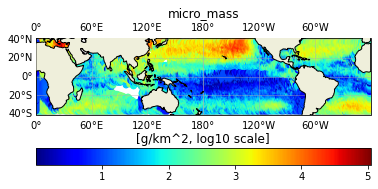

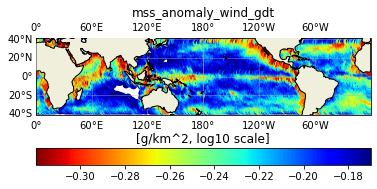

In [98]:
plot_var_2(df, "micro_mass")
#plot_var_2(df, "peaks")
plot_var_2(df, "mss_anomaly_wind_gdt")

In [90]:
fig = px.density_heatmap(df, y="micro_mass", x="mss_anomaly_wind_gdt" , color_continuous_scale=px.colors.sequential.Blackbody)
fig.update_layout(
    xaxis_title= r"$\text{}$",
    yaxis_title= r"$\text{Microplastic mass, (g/km^2, log10 scale)}$",
    legend_title="Legend Title",
    font=dict(size=25,),
)
fig.show()

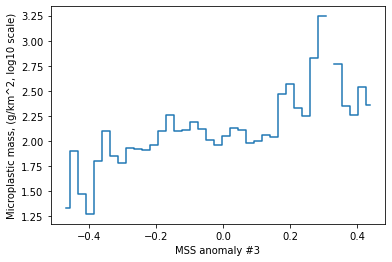

In [80]:
bin_df = pd.DataFrame({'mss':df.mss_anomaly_wind_towards, 'micro' : df.micro_mass })
bin_df['mss_ano'] = pd.cut(bin_df['mss'], bins = np.linspace(bin_df.mss.min(), bin_df.mss.max(), 40)).apply(lambda x: x.left)
bin_df
mean_micro_by_bin = bin_df.groupby(['mss_ano'], as_index=False)['micro'].mean()
mean_micro_by_bin
plt.step(
    mean_micro_by_bin['mss_ano'],
    mean_micro_by_bin['micro'],
    where='mid',
)
plt.xlabel('MSS anomaly #3')
plt.ylabel('Microplastic mass, (g/km^2, log10 scale)')
plt.savefig('mss_ano_3.png')
plt.show()

In [24]:
#Average spatially
def make_data_grided(df):
    df["lon"] = df["lon"].apply(lambda lon: round(lon))
    df["lat"] = df["lat"].apply(lambda lat: round(lat))
    return df

def interp_microplastics(df):
    directory = "C:/Users/syversk/Desktop"
    mic_df = pd.read_csv(directory + "/" + "micro_df.csv")
    interp_micro_mass = LinearNDInterpolator(list(zip(mic_df['lon'], mic_df['lat'])), mic_df['vansebillemodel_mass_log'])
    interp_micro_abu = LinearNDInterpolator(list(zip(mic_df['lon'], mic_df['lat'])), mic_df['vansebillemodel_abundance_log'])
    df['micro_mass'] = interp_micro_mass(df['lon'], df['lat'])
    df['abundace'] = interp_micro_abu(df['lon'], df['lat'])
    return df

#Average all temporally
def group_dataframe_temporally(df):
    df = df.groupby(['lon', 'lat'], as_index=False)[['mss_anomaly_delta_refitted', 'mss_anomaly_wind_refitted'
                                                    , 'mss_anomaly_delta_towards', 'mss_anomaly_wind_towards'
                                                    , 'mss_anomaly_delta_gdt', 'mss_anomaly_wind_gdt']].mean()
    return df


def reduce_based_on_sd(df):
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

def plot_var_2(df, var):
    if var[0:3] != "mic" and var[0:3] != "pea":  
        mycmap = plt.get_cmap('jet').reversed()
    else:
        mycmap = plt.get_cmap('jet')
    proj = ccrs.PlateCarree(180)
    ax = plt.axes(projection=proj)
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines(draw_labels=True, alpha=0.5)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['lon']+180, df['lat'], c=list(df[var]), cmap=mycmap)
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    plt.title(var)
    bar.ax.set_title('[g/km^2, log10 scale]')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('region.png')
    plt.show()
    
def find_highest_corrolation_boundries(df, number_ints ,param = "mss_anomaly_delta_refitted"):
    number = np.linspace(df[param].min(), df[param].max(), number_ints).tolist()
    max_corr = 0
    for numb in number:
        for numb2 in number:
            df_reduced = df[df[param] < numb]
            df_reduced = df_reduced[df_reduced[param]> numb2]
            if len(df_reduced) > len(df)*1/2:
                corr = df_reduced.corr()[param].micro_mass
                if abs(corr) > abs(max_corr):
                    max_corr = corr
                    max_int = numb
                    min_int = numb2
    print(max_corr, max_int, min_int)
    df_reduced_optimally = df[df[param] < max_int]
    return df_reduced_optimally[df_reduced_optimally[param] > min_int] 

def peak_interp(lat, lon):
    df_andreas = pd.read_csv("C:/Users/syversk/Desktop/peaks_fixed/peaks_3_5_winds.csv")
    try:
        return df_andreas[(df_andreas.lat == lat) & (df_andreas.lon == lon)].num_peaks.iloc[0]
    except:
        return np.nan

In [36]:
import datetime
# GOES FROM MONTLY MSS ANOMALY OBSERVATIONS TO ALL TIME MSS ANOMALY WITH MICROPLASTICS INTERPOLTATED 1x1
directory = "C:/Users/syversk/Desktop/anno_np_sp"
files = os.listdir(directory)
df_list = []
for i in tqdm(range(len(files))):
    df_tmp = pd.read_csv(directory + "/" + files[i])
    year = files[i][0:4]
    month = files[i][5:7]
    date = datetime.date(year=int(year), month=int(month), day=1)
    df_tmp["date"] = date   
    df_list.append(df_tmp)
df_all_months = pd.concat(df_list)
df_all_months = interp_microplastics(df_all_months)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 25.25it/s]


In [37]:
south = reduce_area_of_df_pacific(df_all_months, "south")
north = reduce_area_of_df_pacific(df_all_months, "north")
south = pd.DataFrame({"date": south.date, "south": south.mss_anomaly_wind_gdt})
north = pd.DataFrame({"date": north.date, "north": north.mss_anomaly_wind_gdt})

In [32]:
def reduce_area_of_df_pacific(df_all_months, cr):
    if cr == "north":
        df_all_months = df_all_months[df_all_months.lat <= 35]
        df_all_months = df_all_months[df_all_months.lat >= 20]
        df_all_months = df_all_months[df_all_months.lon <= 150]
        df_all_months = df_all_months[df_all_months.lon <= 230]
    else:
        df_all_months = df_all_months[df_all_months.lat <= -20]
        df_all_months = df_all_months[df_all_months.lat >= -35]
        df_all_months = df_all_months[df_all_months.lon <= 150]
        df_all_months = df_all_months[df_all_months.lon <= 230]
    return df_all_months


<AxesSubplot:xlabel='date'>

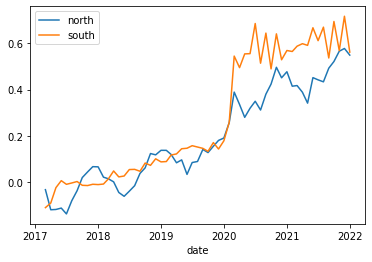

In [35]:
df = pd.concat([south, north])
df = df.groupby(['date'], as_index=False)[['south', "north"]].mean()
df.plot(x='date', y=["north", 'south'])

<AxesSubplot:xlabel='date'>

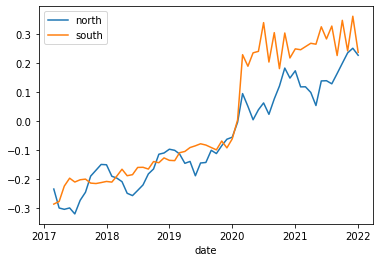

In [38]:
df = pd.concat([south, north])
df = df.groupby(['date'], as_index=False)[['south', "north"]].mean()
df.plot(x='date', y=["north", 'south'])